<a href="https://colab.research.google.com/github/driimus/380ct/blob/master/Investigating%2BTSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Travelling Salesman Problem (TSP) - Metaheuristcs </center></h1>

<p>Adam Nouwailati</p>
<p>Cristian-Iulian Petre</p>
<p>Tiago Filipe Rosário Costa </p>

# Notation and definitions

Let $G$ be a complete weighted graph with $n$ vertices...

- **Complete**: the graph is undirected, has no self-loops, and each node is connected to all the other vertices.
- **Weighted**: the edges have a weight (a positive integer).
- **Cycle**: a path that visits every vertex once, and goes back to the start point.
- **Total cost of the cycle**: sum of the edge weights of the cycle.

# Definition of the problem

Given $G$ as above, the versions of the TSP are defined as follows:

* **Decisional TSP (D-TSP)**:
> Given a total cost $k$, decide if $G$ is has a cycle of length $\leq k$.

    **NP-complete**, because D-TSP $\in$ NP and D-TSP $\leq_p$ HAMCYCLE.
    
    * D-TSP $\in$ NP: once a cycle is given (a certificate) we can quickly evaluate the its cost in $O(n)$ time to verify it is equal to $k$.
    * D-TSP $\leq_p$ HAMCYCLE: Reduction from HAMCYCLE (Hoos and Stutzler, p.25).

* **Search TSP**:
> Given a total cost $k$, search for a cycle of length $\leq k$ in $G$.
> (If found then return it, otherwise say that there is no such cycle.)
    
* **Optimization TSP**:
> Given $G$, find a cycle of minimal total cost.

    **NP-Hard**, because the optimization version of (decision) NP-complete problems are automatically NP-Hard. (using the same method sketched above for **Search TSP**)

The facts about the complexity classes memberships can also be found in (Garey and Johnson, 1979) and (Hoos and Stutzler, 2005).

# Testing methodology

* **Exact methods**:
    Average time for instances with increasing $n$.

* **Greedy and meta-heuristics**:
    Average "quality" as $n$ increases.


## Random instances sampling strategy

General TSP instances will be generated by creating symmetric adjacency matrices uniformly at random.

# Code

First start by importing relevant libraries.

In [0]:
from random import randint, choice
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import exp, log
from time      import time
import matplotlib.pyplot as plt
import copy

## Basics

Let the set of vertices be $\{0, 1, 2,\ldots, n-1\}$.

Without loss of generality, we can consider $0$ to be the start and end point of cycles.

In [0]:
MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    avg_dist = 0
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            avg_dist += v
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix, (avg_dist*2)/(n*(n+1))

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        # a = cycle[i]
        # b = cycle[(i+1)%n]
        c += G[cycle[i]][cycle[i-1]]
    return c

In [0]:
def generate_cycle(G):
    N = len(G)
    taken = [False] * N
    cycle = [0] * N

    for i in range(N-1):
        candidate_idx = randint(0, N-1)
        while taken[candidate_idx]:
            candidate_idx = randint(0, N-1)
        
        cycle[i] = candidate_idx
        taken[candidate_idx] = True

        if i == N-2:
            candidate_idx = 0
            while taken[candidate_idx]:
                candidate_idx += 1

            cycle[i+1] = candidate_idx

    return (cycle, cost(G, cycle))

### Example

In [7]:
G, avg_dist = random_symmetric_graph(5)
show(G)

        0   1   2   3   4
    ---------------------
 0 |    ∞  66  17  83  91
 1 |   66   ∞  15  24   3
 2 |   17  15   ∞  87  32
 3 |   83  24  87   ∞  60
 4 |   91   3  32  60   ∞



# Solution methods

## Exact methods -- Exhaustive search

The idea is to:
- Consider vertex $0$ as the start and end point.
- Iterate over all permutations of the vertices $\{1,2,\ldots, n-1\}$.
    -  Calculate cost of each permutation and keep track of minimum cost permutation.
- Return the cycle with minimum cost.

More formally, the pseudo-code is as follows:

**Input**: $G$.

**Output**: a cycle in $G$ of shortest cost.

1. $bestcycle\gets \emptyset$
2. $bestcost\gets \infty$
3. **for all** possible cycles $p$ in $G$ (starting and ending at $0$) **do**
4. $\quad$ $c\gets$ cost of $p$
2. $\quad$ **if** $c<bestcost$ **then**
3. $\qquad$ $bestcycle\gets p$
3. $\qquad$ $bestcost\gets c$
4. $\quad$ **end if**
5. **end for**
6. **return** $bestcycle, bestcost$

There are $(n-1)!$ possible cycles, and each computation of a cycle's cost costs $O(n)$. So this algorithm costs $$O((n-1)!\cdot n)=O(n!).$$

In [0]:
def exhaustive_search(G):
    n = len(G)    
    best_cost = oo # infinity
    best_cycle = []
    for cycle in permutations(range(1,n)): # permutations of [1,2,...,n]
        cycle=[0]+list(cycle)              # add the starting city: 0
        c = cost(G, cycle)
        if c < best_cost:
            best_cost = c
            best_cycle = cycle
    return (best_cycle, best_cost)

## Testing

In [24]:
pnts_n = []
pnts_t = []

n  = 8
t0 = t1 = 0

while t1-t0<1: # in seconds; if it takes too long then stop testing
    G, avg_dist = random_symmetric_graph(n)
    t0 = time()
    exhaustive_search(G)
    t1 = time()
    # record time
    print( f"{n}\t{t1-t0}" )
    pnts_n.append( n )
    pnts_t.append( t1-t0 )
    n += 1

8	0.007331132888793945
9	0.06705164909362793
10	0.5937376022338867
11	6.359029531478882


Let us plot this data to see it visually.

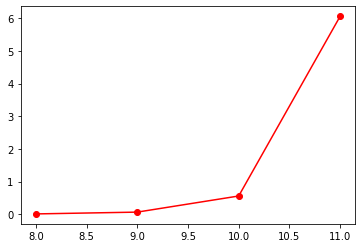

In [10]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

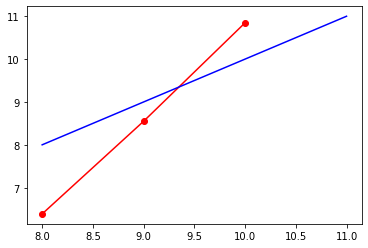

In [11]:
pnts_ratios = [pnts_t[i]/pnts_t[i-1] for i in range(1,len(pnts_n))]
plt.plot(pnts_n[:-1], pnts_ratios, 'ro-')
plt.plot(pnts_n,pnts_n,'b-') # theoretical ratios
plt.show()

### Discussion

* Exhaustive search exhibits combinatorial running time $O(n!)$:
* So it is only useful/possible when $n$ is small, up to about 13 on the current machine if it needs to finish within an hour.

# Approximation

## Greedy search

##### Nearest neigbours

In [0]:
def greedy_nearest_neighbours(G):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    cities = list(range(n))
    cycle = [] # solution to be built
    city = 0 # Start city
    while len(cities)>0:
        # Find nearest neighbour
        city_neighbours = H[city]
        smallest_distance = min(city_neighbours)
        nearest_city = city_neighbours.index(smallest_distance)
        # Update 'cycle' and 'cities' and H then 'city'
        cycle.append(city)
        cities.remove(city)
        for i in range(n): # 'city' is not to be used again!
            H[city][i] = oo
            H[i][city] = oo
        city = nearest_city
    return (cycle, cost(G, cycle))


### Example

In [13]:
G, avg_dist = random_symmetric_graph(4)
show(G)
greedy_nearest_neighbours(G)

        0   1   2   3
    -----------------
 0 |    ∞  67  78  84
 1 |   67   ∞  79   4
 2 |   78  79   ∞  72
 3 |   84   4  72   ∞



([0, 1, 3, 2], 221)

### Test

In [26]:
MAX_REPETITIONS = 100

pnts_n = []
pnts_t = []
pnts_q = []

n = 10
t = 0

while t<10: # in seconds; if it takes too long then stop testing
    t = 0
    expected_cycle_length = (MAX_DISTANCE/2)*n # TODO: Better estimate?
    sum_of_avgs = 0

    sum_of_distances = 0
    for repetitions in range(MAX_REPETITIONS):
        G, avg_dist = random_symmetric_graph(n)
        t0 = time()
        cycle, c = greedy_nearest_neighbours(G)
        t1 = time()

        sum_of_avgs += (avg_dist/2)*n
        sum_of_distances += c
        t += t1-t0
    # record time and quality
    q = (sum_of_distances/MAX_REPETITIONS)/expected_cycle_length
    q2 = sum_of_distances/sum_of_avgs
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_q.append( q )
    print( f"{n}\t{t}\t{q}\t{q2}" )
    n *= 2

10	0.014188528060913086	0.50686	1.23065547138493
20	0.032991886138916016	0.32089	0.7017151628056152
40	0.11436986923217773	0.20037	0.41687383065885003
80	0.44268798828125	0.1227925	0.24953902283503807
160	1.6950342655181885	0.07582125	0.15211099240873116
320	6.895950078964233	0.048915625	0.09745159180438694
640	27.84539270401001	0.0346284375	0.0688020261201788


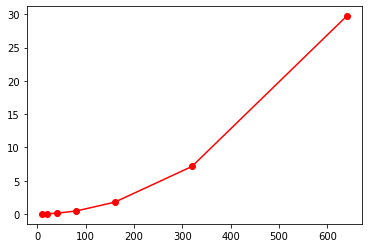

In [8]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

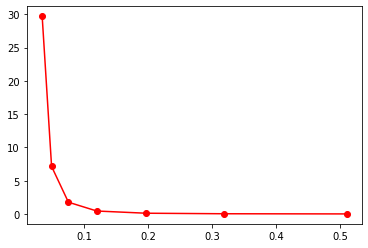

In [9]:
plt.plot(pnts_q, pnts_t, 'ro-')
plt.show()

## Metaheuristics

## 1. Iterative Improvement

### Idea
*   Pre-computed solutions can be passed as input to avoid determining an initial solution.
*   Neighbourhood exploration employs the 2-opt swap technique. A neighbor is defined as any cycle obtained by reversing a subsequence of the current one.
*   The first improved solution is picked on each iteration. Consequently, a subset of each cycle's neighbourhood is ignored in order to speed up the exploration process, but outputs lower quality solutions.


### Pseudocode
**Input**: $G$, $initialCycle$, a function $cost(cycle)$ that returns $cycle$ length

**Output**: local optimum path, length of the path

1. $cycle\gets initialCycle$ **or** $[1, ..., n]$
2. **while** $cycle$ is not a local optimum **do**
3. $\quad$ $improvement\gets$ first neighbour of $cycle$ such that $cost(improvement)<cost(cycle)$
4. $\quad$ $cycle\gets improvement$
5. **end while**
6. **return** $cycle, cost(cycle)$


### Big-O Analysis
Given that
*   Computing an initial solution takes $O(n)$ time at most. For initial solutions determined using a different algorithm, the candidate has to be passed as input, which is a constant time operation even though the runtime of said algorithm is not $O(1)$.
*   The 2-opt swap and cost calculation each take $O(n)$ time
*   At worst, finding an improvement will require exploring all the edges, which takes $O(n^{2})$ time
*   There are at most $2^{2n}$ different permutations of all the 2-opt swaps

The worst-case complexity is
 $$O(2^{n}.n^{2}.(n+n)+n) = O(2^{n}.n^{3})$$


In [0]:
def iterative_improvement(G, cycle=None, best_distance=None):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    cycle = copy.deepcopy(cycle) or list(range(len(H)))
    best_distance = best_distance or cost(H, cycle)
    
    improved = True
    while improved:
        improved = False
        # calculate total dist for existing route 
        best_distance = cost(H, cycle)

        for i in range(0, n-2):
            improved = False
        
            for k in range(i+1, n-1):
                # new_cycle = twoOptSwap(cycle, i, k)
                new_cycle = cycle[:i] + cycle[i:k+1][::-1] + cycle[k+1:]
                new_distance = cost(H, new_cycle)
                
                if new_distance < best_distance:
                    cycle = new_cycle
                    best_distance = new_distance
                    improved = True
                    break
            
            if improved:
                break
                    
    return (cycle, best_distance)

### Test

In [15]:
G, _ = random_symmetric_graph(5)
show(G)
cycle, best_distance = greedy_nearest_neighbours(G) # initial sol

iterative_improvement(G, cycle, best_distance)

        0   1   2   3   4
    ---------------------
 0 |    ∞  78  80  71   4
 1 |   78   ∞  37  35  30
 2 |   80  37   ∞  79  13
 3 |   71  35  79   ∞  78
 4 |    4  30  13  78   ∞



([0, 4, 2, 1, 3], 160)

### Experimentation

There are two configurations to be compared:
*   Naive approach - applying the algorithm without passing an approximate solution as input.
*   Optimisation with Greedy NN - applying the algorithm to the solution computed using Greedy NN.

The algorithm is evaluated on randomised complete graphs of size $n ∈$ { $10,20,...,100$ }, where results are averaged out over 100 repetitions.

Quality is determined by comparing against an estimate cost $e$, based on the true average edge cost of each graph:
 $$e=n.averageEdgeCost$$


In [28]:
MAX_REPETITIONS = 100

pnts_n = []
pnts_t = []; pnts_t_iter = []; pnts_t_iter_naive = []
pnts_t_iter_nn = []
pnts_q = []; pnts_q_iter = []; pnts_q_iter_naive = []

n = 10
t = 0
print( f"sz\tNN\titer" )

while n < 101:
    t = t_iter = t_iter_naive = 0
    sum_of_iter = sum_of_iter_naive = sum_of_inits = 0
    sum_of_avgs = 0
    for repetitions in range(MAX_REPETITIONS):
        G, avg_dist = random_symmetric_graph(n)
        # plain greedy NN
        ti = time()
        cycle, best_distance = greedy_nearest_neighbours(G) # initial sol
        sum_of_inits += best_distance
        # iterative improvement over the greedy solution
        t0 = time()
        cycle, c = iterative_improvement(G, cycle, best_distance)
        t1 = time()
        sum_of_iter += c
        # iterative improvement with no pre-computed solution
        _, c_naive = iterative_improvement(G) 
        t2 = time()
        sum_of_iter_naive += c_naive
        sum_of_avgs += avg_dist*n
        t += t1-t0
        t_iter += t0 - ti
        t_iter_naive += t2 - t1
    # record time and quality
    q = sum_of_inits / sum_of_avgs
    q_iter = sum_of_iter / sum_of_avgs
    q_iter_naive = sum_of_iter_naive / sum_of_avgs
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_t_iter.append( t_iter ); pnts_t_iter_naive.append( t_iter_naive )
    pnts_t_iter_nn.append( t + t_iter )
    pnts_q.append( q )
    pnts_q_iter.append( q_iter ); pnts_q_iter_naive.append( q_iter_naive )
    print( f"{n}\t{t: .2f}\t{t_iter: .2f}\t{t_iter_naive: .2f}\t{q: .5f}" )
    n += 10

sz	NN	iter
10	 0.03	 0.01	 0.05	 0.61279
20	 0.19	 0.03	 0.41	 0.35670
30	 0.67	 0.07	 1.68	 0.25679
40	 1.80	 0.12	 4.76	 0.20872
50	 3.61	 0.18	 10.46	 0.17748
60	 6.44	 0.26	 20.52	 0.15344
70	 10.84	 0.34	 36.92	 0.13657
80	 17.14	 0.44	 55.54	 0.12314
90	 25.42	 0.56	 84.22	 0.11367
100	 34.75	 0.69	 128.23	 0.10590


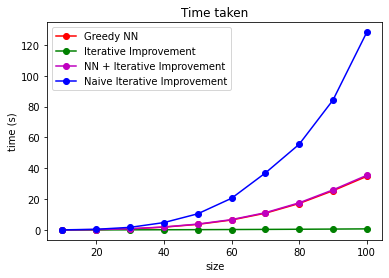

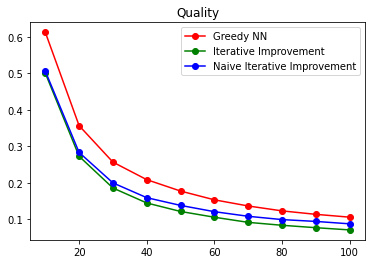

In [30]:
plt.title('Time taken')
plt.xlabel('size'); plt.ylabel('time (s)')
plt.plot(pnts_n, pnts_t, 'ro-')
plt.plot(pnts_n, pnts_t_iter, 'go-')
plt.plot(pnts_n, pnts_t_iter_nn, 'mo-')
plt.plot(pnts_n, pnts_t_iter_naive, 'bo-')
plt.legend(['Greedy NN', 'Iterative Improvement', 'NN + Iterative Improvement', 'Naive Iterative Improvement'])
plt.show()
plt.title('Quality')
plt.plot(pnts_n, pnts_q, 'ro-')
plt.plot(pnts_n, pnts_q_iter, 'go-')
plt.plot(pnts_n, pnts_q_iter_naive, 'bo-')
plt.legend(['Greedy NN', 'Iterative Improvement', 'Naive Iterative Improvement'])
plt.show()

Both configurations will usually produce improved solutions compared to Greedy approximation. However, the naive approach is not only considerably slower, but also worse than the optimised approach.

Therefore, Iterative Improvement is more suitable for exploring the neighbourhood of a good solution for a local optimum - especially when paired with a fast approximation algorithm such as Greedy Nearest Neighbor.

Another advantage is applicability to graphs with more than 100 nodes, as the exponential time complexity is amotized when using a pre-computed solution.

## 2. Simulated Annealing

### Idea

This approach builds on the iterative improvement algorithm by introducing the following mechanics:
*   Each iteration explores a subset of the current candidate's neighbourhood and moves to the best neighbor. Since Simulated Annealing allows for fine-grained configurability, the increased computation time can be mitigated by tuning the configuration parameters.
*   The algorithm starts with the maximum temperature and decreases it logarithmically.
*   A computational budget is allocated for trying to escape local minima. The budget is expended once enough iterations have passed without finding an improved solution candidate. Since there is no way for the algorithm to know when the global optimum has been reached, this serves as the termination criteria.

### Pseudocode
**Input**: $G$, $maxTemperature$, $coolingFactor$, $k$

**Output**: a cycle in $G$, computed cycle cost

1. Determine initial candidate solution $cycle$
2. $T\gets maxTemperature$
3. **while** global optimum not reached **do**
4. $\quad$ $next \gets$ best neighbour of $cycle$ in $k$ optimisations
5. $\quad$ **if** $cost(next) < cost(cycle)$  **then**
6. $\qquad$ $cycle \gets next$
7. $\quad$ **end if**
8. $\quad$ $T \gets T$ * $coolingFactor$
9. **end while**

10. **return** $cycle, cost(cycle)$

### Big-O Analysis
Given the follwing configuration parameters (that will usually not exceed the graph size):
*   $k$ - criterion for the temperature lowering stage, represented as a computational budget 
*   $t$ - initial temperature

And the linear time complexity for 2-opt swaps, a single Simulated Annealing iteration has polynomial time complexity:
 $$O(n.k.(t.n)) = O(n^{2}.k.t) ≈ O(n^4)$$


In [0]:
# SA constants, used for tuning the algo

start_temperature = 15.
stop_temperature = 5.
MAX_CYCLES = 10
UNCHANGED_FOR_MAX = 500

# temperature scheduling
temp_dropoff = exp(log(stop_temperature / start_temperature) / (MAX_CYCLES-1))

def sa_set(start_temp = 20., stop_temp = 5., cycles = 10, budget = 50):
    global start_temperature, stop_temperature, MAX_CYCLES, UNCHANGED_FOR_MAX
    start_temperature = start_temp
    stop_temperature = stop_temp
    MAX_CYCLES = cycles
    UNCHANGED_FOR_MAX = budget

    global temp_dropoff
    temp_dropoff = exp(log(stop_temperature / start_temperature) / (MAX_CYCLES-1))


def sa_reset():
    sa_set()

In [0]:
def randomize(cycle, temperature):
    n = len(cycle) - 1
    for _ in range(int(temperature)):
        idx1 = randint(0, n)
        nxt1 = (idx1+1) % (n+1)
        idx2 = randint(0, n)
        nxt2 = (idx2+1) % (n+1)

        distance = G[cycle[idx1]][cycle[nxt1]] \
                 + G[cycle[idx2]][cycle[nxt2]] \
                 - G[cycle[idx1]][cycle[idx2]] \
                 - G[cycle[nxt1]][cycle[nxt2]]
        if distance > 0:
            # sort indices in ascending order
            if idx2 < idx1:
                idx1, idx2 = idx2, idx1
                nxt1, nxt2 = nxt2, nxt1
            cycle = cycle[:nxt1] + cycle[nxt1:idx2][::-1] + cycle[idx2:]

    return cycle

In [0]:
def sa_iteration(G, cycle, best_distance):
    # set initial temp
    temperature = start_temperature

    new_cycle = copy.deepcopy(cycle)
    for _ in range(MAX_CYCLES):
        new_cycle = randomize(new_cycle, temperature)
        new_distance = cost(G, new_cycle)
        
        if new_distance < best_distance:
            cycle = copy.deepcopy(new_cycle)
            best_distance = new_distance

        new_cycle = copy.deepcopy(cycle)
        temperature *= temp_dropoff

    return (cycle, best_distance)

In [0]:
def simulated_annealing(G, cycle = None, best_distance = None):
    cycle = copy.deepcopy(cycle) or list(range(len(G)))
    best_distance = best_distance or cost(G, cycle)

    distance = best_distance - 1

    # iterate until a local minimum is found
    unchanged_for = 0
    while unchanged_for < UNCHANGED_FOR_MAX:
        if best_distance == distance:
            unchanged_for += 1
        else:
            distance = best_distance
            unchanged_for = 0
            cycle, best_distance = sa_iteration(G, cycle, distance)
    
    return (cycle, best_distance)

In [35]:
G, _ = random_symmetric_graph(5)
show(G)
cycle, best_distance = greedy_nearest_neighbours(G) # initial sol

simulated_annealing(G)

        0   1   2   3   4
    ---------------------
 0 |    ∞  23  58  39  22
 1 |   23   ∞  81  45  64
 2 |   58  81   ∞  45  60
 3 |   39  45  45   ∞  46
 4 |   22  64  60  46   ∞



([0, 1, 2, 3, 4], 217)

### Experimentation

Due to the limit in computational budget for escaping local minima, Simulated Annealing provides negligible enhancements when used with an initial solution.

Instead, the naive approach is tested on graphs up to 1000 nodes in size, with results averaged out over 100 repetitions.

In [101]:
MAX_REPETITIONS = 100

pnts_n = []
pnts_t = []; pnts_t_sa = []
pnts_q = []; pnts_q_sa = []

n = 50
t = 0
print( f"sz\titer\tNN\tQ1" )

while n < 1001:
    t = t_iter = t_sa = 0
    sum_of_distances = sum_of_inits = sum_of_sa = 0
    sum_of_avgs = 0
    for repetitions in range(MAX_REPETITIONS):
        G, avg_dist = random_symmetric_graph(n)
        ti = time()
        cycle, best_distance = greedy_nearest_neighbours(G) # initial sol
        sum_of_inits += best_distance
        t0 = time()
        # _, c = iterative_improvement(G, cycle, best_distance)
        t1 = time()
        # _, sa = simulated_annealing(G, cycle, best_distance)
        _, sa = simulated_annealing(G)
        t2 = time()
        sum_of_distances += c
        sum_of_sa += sa
        sum_of_avgs += avg_dist*n
        t_sa += t2 - t1
        t_iter += t1-t0
        t += t0 - ti
    # record time and quality
    q = sum_of_inits / sum_of_avgs
    # qi = sum_of_distances / sum_of_avgs
    q_sa = sum_of_sa / sum_of_avgs
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_t_sa.append( t_sa )
    pnts_q.append( q )
    pnts_q_sa.append( q_sa )
    # print( f"{n}\t{t: .2f}\t{t_iter: .2f}\t{t_sa: .2f}\t{q: .5f}\t{qi: .5f}\t{q_sa: .5f}" )
    print( f"{n}\t{t: .2f}\t{t_sa: .2f}\t{q: .5f}\t{q_sa: .5f}" )
    n += 50

sz	iter	NN	Q1
50	 0.18	 0.58	 0.17853	 0.57524
100	 0.70	 1.44	 0.10576	 0.58086
150	 1.54	 2.44	 0.07769	 0.60601
200	 2.75	 4.12	 0.06480	 0.60033
250	 4.30	 5.50	 0.05659	 0.62137
300	 6.22	 7.69	 0.04991	 0.62323
350	 8.49	 9.53	 0.04590	 0.63700
400	 11.33	 11.75	 0.04361	 0.64218
450	 14.21	 13.75	 0.04100	 0.65889
500	 17.66	 16.74	 0.03874	 0.65764
550	 21.35	 20.50	 0.03680	 0.65478
600	 25.57	 23.95	 0.03528	 0.65804
650	 29.98	 26.12	 0.03455	 0.66731
700	 35.13	 29.18	 0.03327	 0.67438
750	 40.20	 33.93	 0.03206	 0.66758
800	 46.62	 38.03	 0.03171	 0.66968
850	 53.17	 42.29	 0.03098	 0.67516
900	 59.77	 44.82	 0.03028	 0.68033
950	 66.74	 48.59	 0.02995	 0.68947
1000	 78.29	 58.88	 0.02912	 0.67154


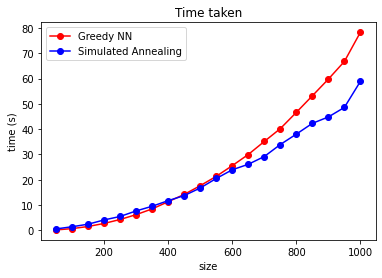

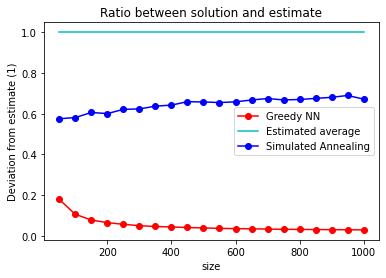

In [102]:
plt.title('Time taken')
plt.xlabel('size'); plt.ylabel('time (s)')
plt.plot(pnts_n, pnts_t, 'ro-')
plt.plot(pnts_n, pnts_t_sa, 'bo-')
plt.legend(['Greedy NN', 'Simulated Annealing'])
plt.show()

plt.title('Ratio between solution and estimate')
plt.xlabel('size'); plt.ylabel('Deviation from estimate (1)')
plt.plot(pnts_n, pnts_q, 'ro-')
plt.plot(pnts_n, [1] * len(pnts_q), 'c-')
plt.plot(pnts_n, pnts_q_sa, 'bo-')
plt.legend(['Greedy NN', 'Estimated average', 'Simulated Annealing'])
plt.show()

It is noted that naive Simulated Annealing tends to provide slightly better than average results with runtimes comparable to Greedy NN.

It is noted that the default configuration causes execution times to plateau for graphs with more than 500 nodes. This highlights the importance of knowing the problem instance when applying Simulated Annealing to it (Dréo 2011). Trying to use a general-purpose configuration across a large scope of problems will result in subpar results for some, if not all, of the problems.

# Conclusion

In [0]:
URL = "https://raw.githubusercontent.com/driimus/380ct/master/eil101.xml?token=AJZHHXZHAZXDJXF2OOF6X4C6TCIOQ"

from google.colab import files
uploaded = files.upload()

Saving ch130.xml to ch130.xml
Saving eil76.xml to eil76.xml
Saving eil101.xml to eil101.xml
Saving kroA150.xml to kroA150.xml
Saving pr299.xml to pr299.xml
Saving rd100.xml to rd100.xml
Saving rd400.xml to rd400.xml
Saving u159.xml to u159.xml


### Testing on published TSPLIB problem instances

In order to provide a more accurate depiction of how the algorithms perform, 8 TSPLIB datasets, varying from 76 to 400 elements in size, are tested in addition to randomly generated graphs. The datasets are available on Heidelberg University's website as well as directly through the github repository.

In [0]:
import pandas as pd 
import xml.etree.ElementTree as et 

def fileParser(file):
  xtree = et.parse(file)
  xroot = xtree.getroot()
  graph=[]
  i=0
  for vertex in xroot.find('graph'):
    temp=[]
    for edge in vertex:
      temp.append(float(edge.get('cost')))
    temp.insert(i, oo)
    i += 1
    graph.append(temp)
  
  return graph

names=["GNN", "II", "SA"]

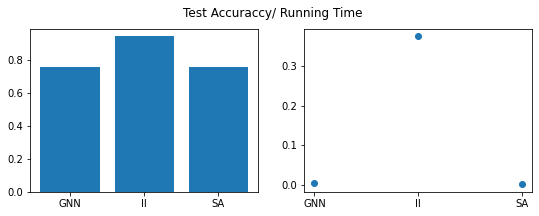

In [0]:
graph76 = fileParser("eil76.xml")

# #Graph76
Opt_Sol = 538
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph76)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph76, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph76, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

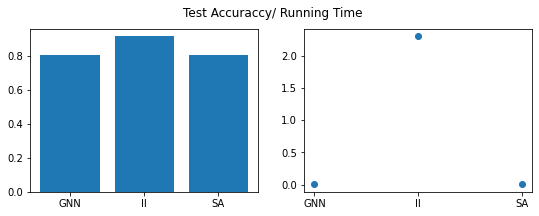

In [0]:
graph130 = fileParser("ch130.xml")

# #Graph130
Opt_Sol = 6110
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph130)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph130, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph130, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

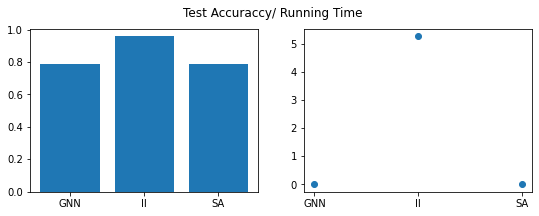

In [0]:
graph150 = fileParser("kroA150.xml")

# #Graph150
Opt_Sol = 26524
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph150)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph150, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph150, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

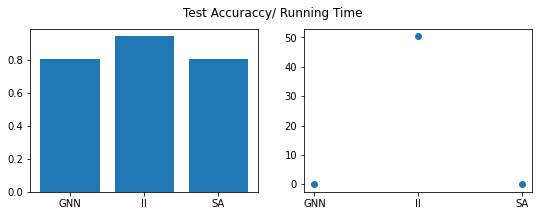

In [0]:
graph299= fileParser("pr299.xml")

# #Graph299
Opt_Sol = 48191
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph299)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph299, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph299, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

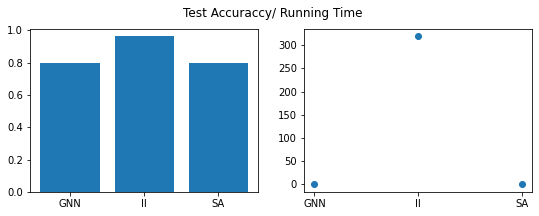

In [0]:
graph400 = fileParser("rd400.xml")

# #Graph400
Opt_Sol = 15281
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph400)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph400, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph400, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

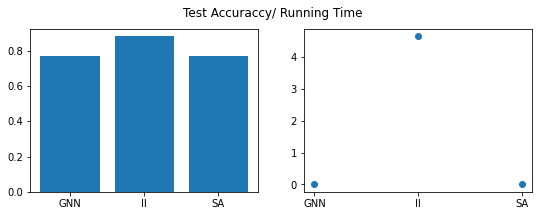

In [0]:
graph159 = fileParser("u159.xml")

# #Graph159
Opt_Sol = 42080
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph159)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph159, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph159, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

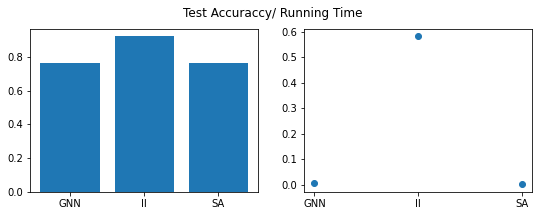

In [0]:
graph101 = fileParser("eil101.xml")

# #Graph101
Opt_Sol = 629
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph101)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph101, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph101, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

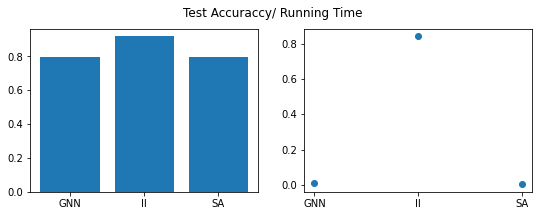

In [0]:
graph100 = fileParser("rd100.xml")

# #Graph100
Opt_Sol = 7910
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph100)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph100, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph100, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

### Recommendation

From the analyse of the graphs we can reach two conclusions, first Simulated Annealing method is faster overall in runtime execution that Iterative Improvement, while Iterative Improvement is more accurate when reaching a solution. This comes as result of trading speed for accuracy when on the implementations.

The results above can be improved for the Simulated Annealing metaheuristic by tailoring the configuration parameters to each problem instance. For this set of tests, the default parameters are used to ensure consistency when transitioning between datasets.

Based on our experiments we can recommend the usage of Iterative Improvement when searching for a more accurate result that is closer to the optimal value if one does not have any time constrains. 
If a time constraint does exist Simulated Annealing would be the optimal algorithm as it is faster, and it can be tuned to provide more accurate results although the accuracy would still be lower than that of Iterative Improvement.


# References

* Dréo J. (2011) *Metaheuristics for Hard Optimization: Methods and Case Studies*. Berlin: Springer

* Engels, C. and Manthey, B. (2009) “Average-Case Approximation Ratio of the 2-Opt Algorithm for the TSP”. *Operations Research Letters* 37, 83–84

* Garey, S. and Johnson, D. (1979) *Computers and Intractability: A Guide to the Theory of NP-Completeness*. Freeman

* Hoos, H. and Stutzler, T. (2005) *Stochastic Local Search: Foundations and Applications.* Morgan Kaufmann

* Sasaki, G.H. and Hajek, B. (1988) “The Time Complexity of Maximum Matching by Simulated Annealing”. *Journal of the ACM (JACM)* 35, 387–403

* Sipser, M. (2013) *Introduction to the theory of computation
(3rd international ed.)*. Cengage Learning.

* TSPLIB/Ruprecht-Karls-Universität Heidelberg (n.d) available from <http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/index.html> [01/04/2020]